The Experiment for **Tanh** Function using three different weight nitialization methods.
+ Uniform
+ Default
+ Xavier

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(2)

In [2]:
# Create Dataset
train_dataset = dataset.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
valid_dataset = dataset.MNIST(root='./data', download=True, transform=transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 304412245.43it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 105518897.06it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 170834458.82it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




100%|██████████| 4542/4542 [00:00<00:00, 18143360.73it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [24]:
# Xavier Uniform Method
class Net_Tanh_Xavier(nn.Module):
    def __init__(self, Layers):
        super(Net_Tanh_Xavier, self).__init__()
        self.hidden = nn.ModuleList()     # ModuleList có chức năng chứa các Linear Object
        for input_dim, output_dim in zip(Layers, Layers[1:]):
            linear = nn.Linear(input_dim, output_dim)
            nn.init.xavier_uniform(linear.weight)
            self.hidden.append(linear)

    def forward(self, x):
        L = len(self.hidden)
        for i,linear in zip(range(L), self.hidden):
            if i < L - 1:
                x = torch.tanh(linear(x))
            else:
                x = linear(x)
        return x

In [13]:
# Defaul Method
class Net_Tanh_Defaul(nn.Module):
    def __init__(self, Layers):
        super(Net_Tanh_Defaul, self).__init__()
        self.hidden = nn.ModuleList()
        for input_dim,output_dim in zip(Layers, Layers[1:]):
            linear = nn.Linear(input_dim, output_dim)
            self.hidden.append(linear)

    def forward(self, x):
        L = len(self.hidden)
        for i,linear in zip(range(L), self.hidden):
            if i < L-1:
                x = torch.tanh(linear(x))
            else:
                x = linear(x)
        return x

sử dụng hàm linear.weight.data.uniform_ tạo ngẫu nhiên giá trị w trong khoảng cho trước, có thể sử dụng tham số 'state_dict()' để truyền tham số nhưng nếu làm
vậy thì sẽ phải tính đầu truyền vào đầy đủ 1 ma trận là tất cả các w của các neural. Chỉ lên dùng 'state_dict' để xem tham số hoặc với các mạng 1 tầng ẩn thôi.

In [23]:
# Tạo ngẫu nhiên bộ trọng số trong khoảng (0,1)
class Net_Tanh_Uniform(nn.Module):
    def __init__(self, Layers):
        super(Net_Tanh_Uniform, self).__init__()
        self.hidden = nn.ModuleList()
        for input_dim,output_dim in zip(Layers, Layers[1:]):
            linear = nn.Linear(input_dim, output_dim)
            linear.weight.data.uniform_(0, 1)  # Tạo ngẫu nhiên w trong khoảng (0,1).
            self.hidden.append(linear)

    def forward(self, x):
        L = len(self.hidden)
        for i,linear in zip(range(L), self.hidden):
            if i < L-1:
                x = torch.tanh(linear(x))
            else:
                x = linear(x)
        return x

In [6]:
trainloader = DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validloader = DataLoader(dataset=valid_dataset, batch_size=5000, shuffle=False)

In [7]:
criterion = nn.CrossEntropyLoss()

In [19]:
ACC = {'Xavier': [], 'Default': [], 'Uniform': []}
COST = {'Xavier': [], 'Default': [], 'Uniform': []}

def training(model, optimizer, epochs, method_name):
    for epoch in range(epochs):
        total_loss = 0
        for x,y in trainloader:
            yhat = model(x.view(-1, 28*28))
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        COST[method_name].append(total_loss)

        correct = 0
        for x,y in validloader:
          yhat = model(x.view(-1, 28*28))
          _,label = torch.max(yhat, 1)
          correct += (label==y).sum().item()
        accuracy = 100 * correct/ len(valid_dataset)
        ACC[method_name].append(accuracy)

In [9]:
learning_rate = 0.01
epochs = 10
input_dim = 28*28
output_dim = 10
Layers = [input_dim, 100, 100, 100, output_dim]

In [20]:
model_default = Net_Tanh_Defaul(Layers)
optimizer_default = optim.SGD(model_default.parameters(), lr=learning_rate)
training(model_default, optimizer_default, epochs, method_name='Default')

In [25]:
model_uniform = Net_Tanh_Uniform(Layers)
optimizer_uniform = optim.SGD(model_uniform.parameters(), lr=learning_rate)
training(model_uniform, optimizer_uniform, epochs, method_name='Uniform')

In [26]:
model_xavier = Net_Tanh_Xavier(Layers)
optimizer_xavier = optim.SGD(model_xavier.parameters(), lr=learning_rate)
training(model_xavier, optimizer_xavier, epochs, method_name='Xavier')

<ipython-input-24-2bcaa8f89924>:8: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(linear.weight)


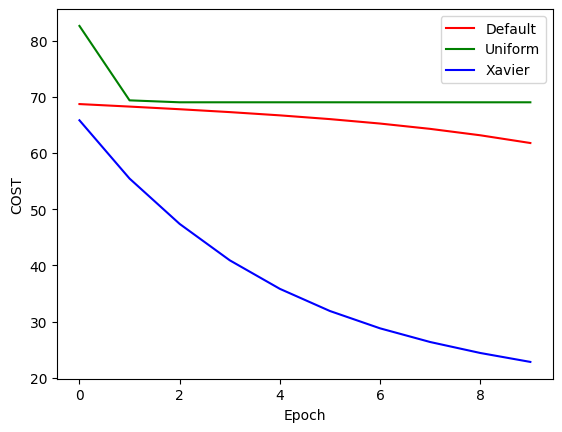

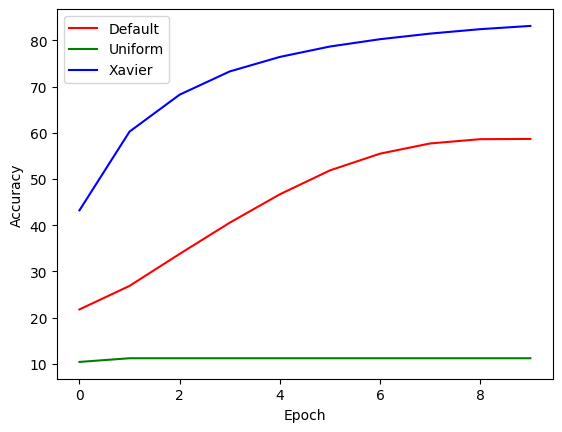

In [34]:
# Compare result
plt.plot(COST['Default'], label='Default', color='red')
plt.plot(COST['Uniform'], label='Uniform', color='green')
plt.plot(COST['Xavier'], label='Xavier', color='blue')
plt.xlabel('Epoch')
plt.ylabel('COST')
plt.legend()
plt.show()

plt.plot(ACC['Default'], label='Default', color='red')
plt.plot(ACC['Uniform'], label='Uniform', color='green')
plt.plot(ACC['Xavier'], label='Xavier', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Nhận xét**: Xavier cao nhất, đến Default, còn tự tạo thì rất tệ

